# Statistical Learning, Lab #5: SVMs

[In the textbook: Section 9.6.1]

Here we will use the `SVC` class from the Scikit-learn package (`sklearn`), which implements support vector classification.

If you run this notebook on Google Colab, type `!pip install ISLP` in the following code cell and run it (it will take a while). Then, restart your session (Runtime menu > Restart session).

In [1]:
# support libraries
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
import sklearn.pipeline as pipeline

# lab-specific libraries
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from ISLP.svm import plot as plot_svm

## Support Vector Classifier

The function for fitting a support vector classifier is `SVC(C, kernel, ...)`, with `kernel="linear"`. **Note that** this implementation uses the dual problem, so `C` here represents the cost of a violation to the margin:

* small cost -> wide margins, many support vectors on the margins;
* large cost -> narrow margins, few support vectors on the margins.

We begin by generating some random data in two classes, using two variables so that we can plot the resulting decision boundary.

We plot the generated data to check whether the classes are linearly separable (they are not).

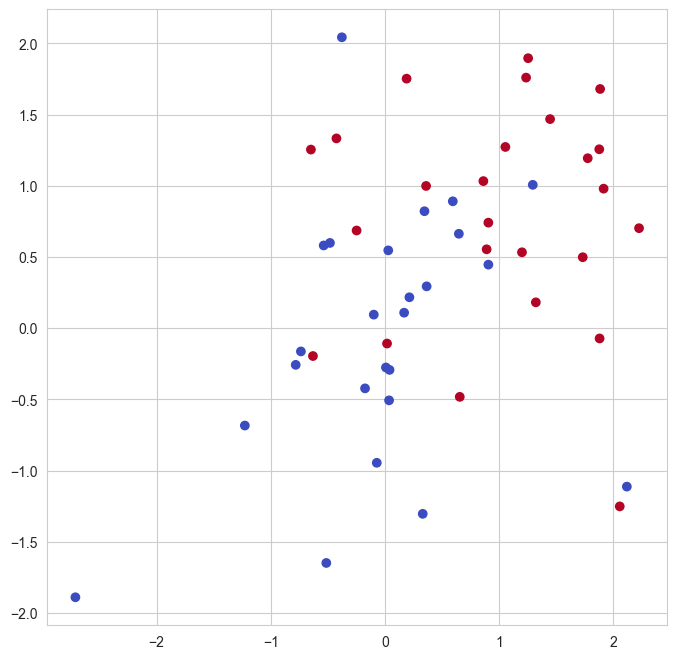

In [2]:
# set the random seed
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))  # a data matrix
y = np.array([-1] * 25 + [1] * 25)  # a label vector
X[y == 1] += 1  # shifting by (1,1) all points with class 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

Now we fit a **support vector classifier** with an arbitrary value of the cost `C`.

In [3]:
svm_linear = SVC(C=10, kernel="linear")
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

We can plot the data together with the decision boundary by using the ISLP function `plot_svm()` with the SVC fit and the original data.

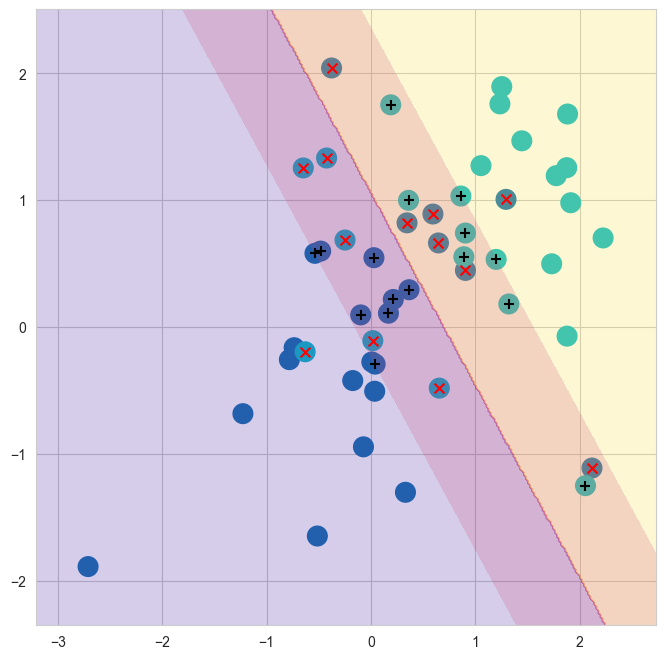

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear, ax=ax)

Since we used a linear kernel, the decision boundary is linear. Crosses (`+`) indicate the support vectors and the remaining observations are plotted as circles.

In [5]:
# number of support vectors
svm_linear.support_vectors_.shape[0]

29

In [6]:
# number of support vectors by class
svm_linear.n_support_

array([15, 14], dtype=int32)

What changes if we use a smaller cost parameter?

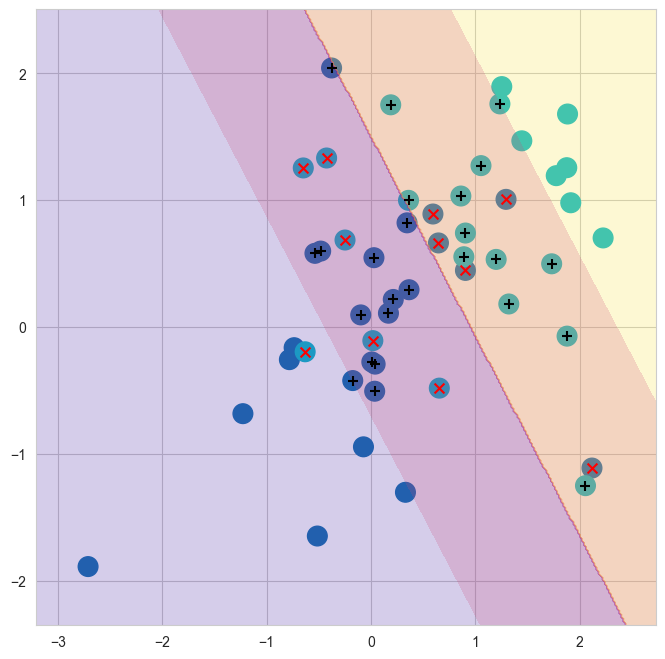

In [7]:
svm_linear_small = SVC(C=0.1, kernel="linear")
svm_linear_small.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear_small, ax=ax)

The number of support vectors increases (wider margin). 

In [8]:
svm_linear_small.support_vectors_.shape[0]

36

In [9]:
svm_linear_small.n_support_

array([18, 18], dtype=int32)

We can extract the coefficients of the linear decision boundary as follows:

In [10]:
svm_linear_small.coef_

array([[0.71529828, 0.45433662]])

### How to compute the decision boundary line

For a 2D dataset (features $x_0$, $x_1$), the equation of the decision boundary is

$$w_0x_0 + w_1x_1 + b = 0$$

We get $w_0$, $w_1$ from `svm_linear.coef_` and $b$ from `svm_linear.intercept_`.

Rewriting the decision boundary equation in the form

$$x_1 = mx_0 + c$$

we then derive the slope and intercept as follows:

- $m = -\frac{w_0}{w_1}$
- $c = -\frac{b}{w_1}$

In [11]:
w = svm_linear_small.coef_[0]
b = svm_linear_small.intercept_[0]

In [12]:
m = -w[0] / w[1]
c = -b / w[1]

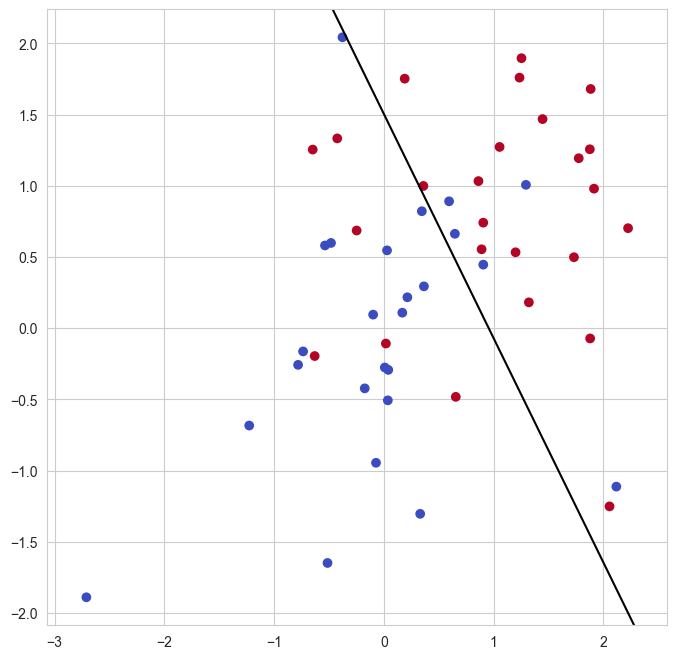

In [13]:
x_vals = np.linspace(min(X[:, 0]) - 0.1, max(X[:, 0]) + 0.1, 100)
y_vals = c + m * x_vals

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
ylim = ax.get_ylim()
ax.plot(x_vals, y_vals, color="k")
ax.set_ylim(ylim)
plt.show()

## Hyperparameter tuning

An optimal value for the `C` parameter can be found by trying different values in a cross-validation setting. 

In scikit-learn, cross-validation is performed with a "splitter" generator contained in the [model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html) submodule. For example, K-Fold is implemented in the class `KFold(n_splits)`.

Exhaustive grid search via cross-validation is performed with the `GridSearchCV(model, param_grid, cv, ...)` function, where:
- `model` is a scikit-learn "estimator"
- `param_grid` is a Python dictionary whose keys are parameter names and whose values are lists of parameter settings to try (e.g., `{'C': [1, 10, 100]}`)
- `cv` is either a splitter object or an integer specifying the number of folds of a plain K-Fold CV. Passing a splitter object allows for more flexibility.

In [14]:
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]

kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(
    svm_linear,
    {"C": C_values},
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)
grid.fit(X, y)
grid.best_params_

{'C': 1}

The cross-validation metrics for each of these models are stored in the attribute `grid.cv_results_`

In [15]:
grid.cv_results_

{'mean_fit_time': array([0.00041437, 0.00023828, 0.00019541, 0.00020609, 0.00021839,
        0.00022545, 0.00033569]),
 'std_fit_time': array([1.13168336e-04, 3.30106344e-05, 1.04105685e-05, 1.00380734e-05,
        1.19931892e-05, 1.47562419e-05, 5.41146102e-05]),
 'mean_score_time': array([0.00036488, 0.00023155, 0.00019622, 0.00019956, 0.00021443,
        0.00020313, 0.00019927]),
 'std_score_time': array([9.51378682e-05, 2.72279445e-05, 6.55716113e-06, 3.44182633e-06,
        6.66822285e-06, 4.47312904e-06, 2.41451052e-06]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.3, 0.3, 0.8, 0.8, 0.8, 0.8, 0.8]),
 'split2_test_score': array([0.6, 0.6, 0.8, 0.9, 0.9, 0.9

The performance is quantified in terms of CV accuracy (as we specified earlier).
We just extract the accuracy values:

In [16]:
grid.cv_results_["mean_test_score"]

array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

In [17]:
C_values

[0.001, 0.01, 0.1, 1, 5, 10, 100]

We see that  `C=1` results in the highest cross-validation accuracy of 0.74, though the accuracy is the same for several values of `C`. To extract the optimal `C` value programmatically:

In [18]:
grid.best_params_

{'C': 1}

The best model, corresponding to the optimal `C`, is also stored as the attribute `best_estimator_`:

In [19]:
bestmod = grid.best_estimator_
bestmod

SVC(C=1, kernel='linear')

We now use the `predict()` method to predict class labels using the best model.

To this aim, we generate a set of test observations:

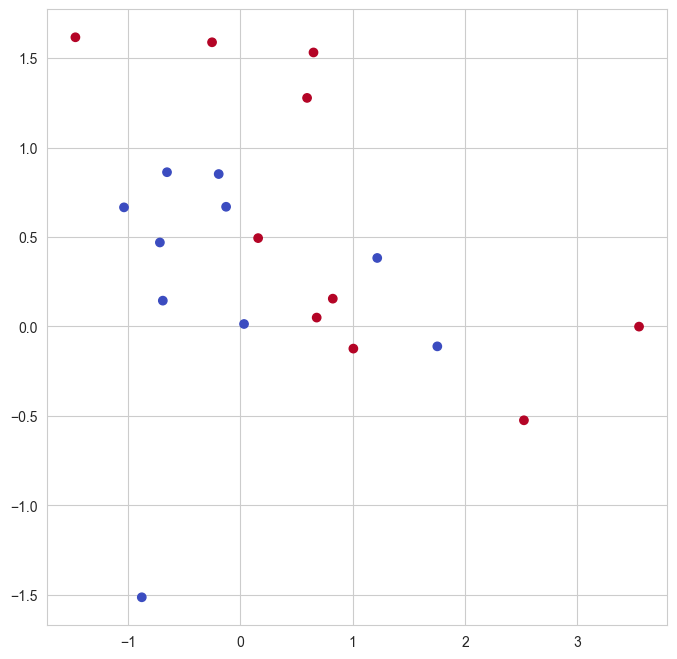

In [20]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1] * 10 + [1] * 10)
X_test[y_test == 1] += 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm);

In [21]:
ypred = bestmod.predict(X_test)
ypred

array([-1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1, -1,  1])

In [22]:
# our usual confusion matrix
confusion_table(ypred, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


In [23]:
# accuracy
(ypred == y_test).mean()

np.float64(0.7)

Thus, with this value of `C`, 70% of the test observations are correctly classified.  What if we had instead used `C=0.01`?

In [24]:
svm_mod = SVC(C=0.01, kernel="linear")
svm_mod.fit(X, y)

ypred = svm_mod.predict(X_test)
confusion_table(ypred, y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


In [25]:
# accuracy
(ypred == y_test).mean()

np.float64(0.6)

In this case 60% of test observations are correctly classified.

## Linearly separable classes

If we further separate the two classes in our simulated `X` matrix, they are now linearly separable:

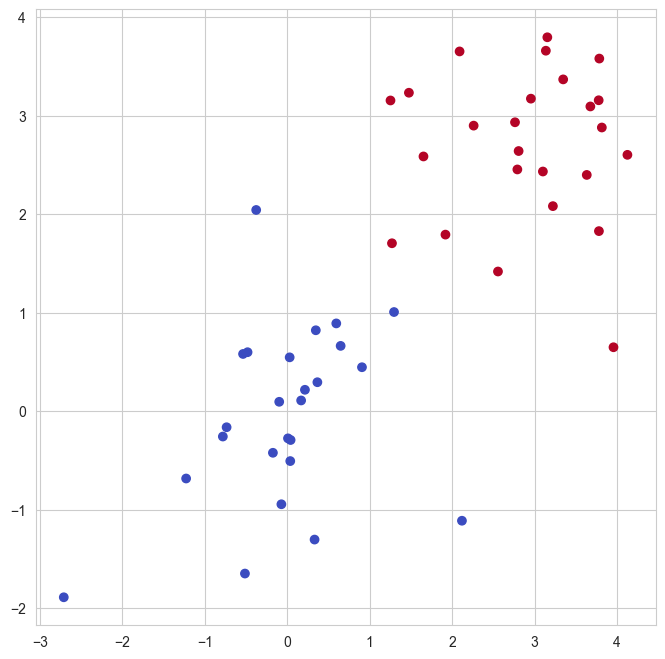

In [26]:
X[y == 1,] += 1.9

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

We fit a support vector classifier on these new data, with a large value for `C` in order to obtain no misclassifications.

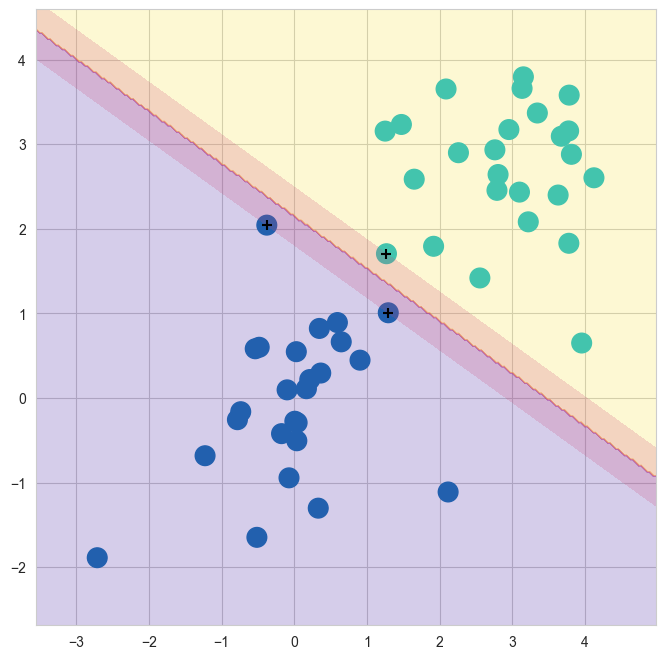

In [27]:
svm_mod = SVC(C=1e5, kernel="linear")
svm_mod.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X, y, svm_mod, ax=ax)

All observations are perfectly classified. Only 3 support vectors were used: that's because we used a large value of `C`, which also means that these support vectors are on the margin, and define it.

_What do you think of this model? How are the margins? How do you think it will perform on unseen test data?_

One may wonder how good the classifier could be on test data that depends on only three data points!

The confusion matrix also shows that there are no misclassifications:

In [28]:
y_hat = svm_mod.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


We fit another model with a smaller `C` (say, 0.1):

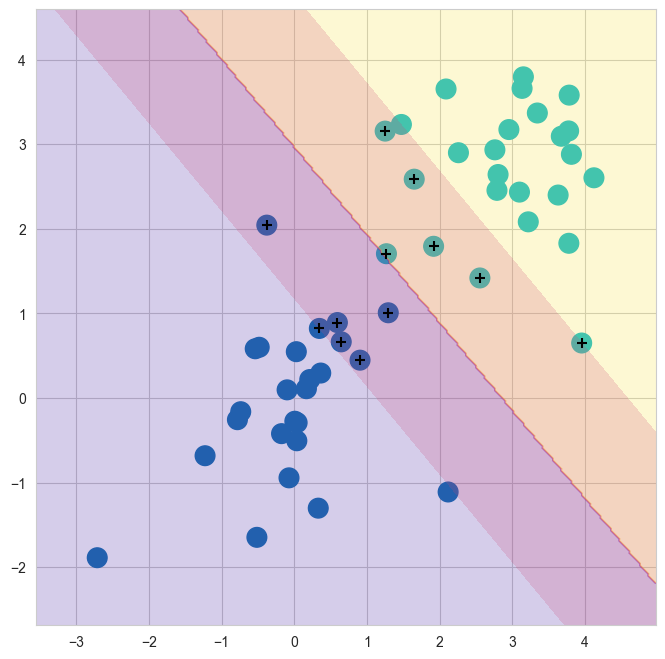

In [29]:
svm_mod = SVC(C=0.1, kernel="linear")
svm_mod.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X, y, svm_mod, ax=ax)

In [30]:
svm_mod.support_vectors_.shape[0]

12

In [31]:
y_hat = svm_mod.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


Using `C=0.1`, we do not misclassify any training observations, but also obtain a much wider margin and make use of 12 support vectors. These jointly define the orientation of the decision boundary, and since there are more of them, it is more stable. It seems possible that this model will perform better on test data than the model with `C=1e5`. Let's verify by generating some test data, like before:

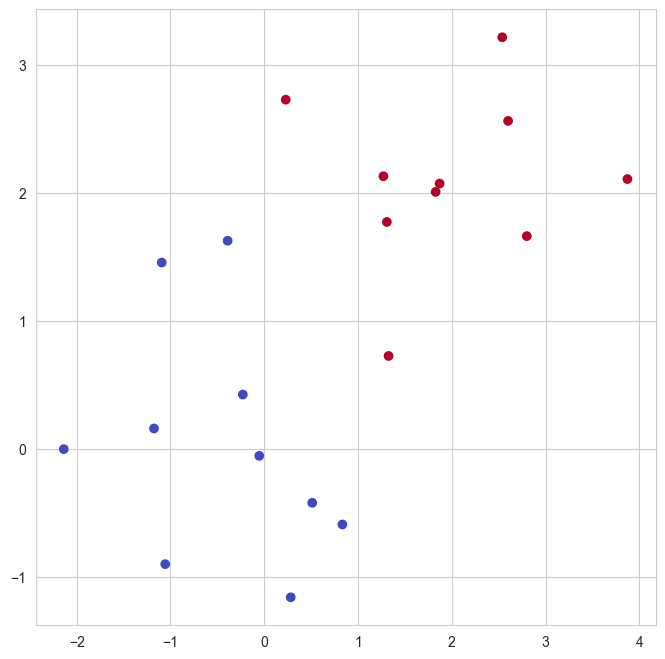

In [32]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1] * 10 + [1] * 10)
X_test[y_test == 1] += 1.9

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm);

In [33]:
ypred = svm_mod.predict(X_test)
confusion_table(ypred, y_test)

Truth,-1,1
Predicted,,
-1,10,2
1,0,8


In [34]:
# accuracy
(ypred == y_test).mean()

np.float64(0.9)

# Support Vector Machine

[In the textbook: Section 9.6.2]

So far we used a linear kernel Support Vector Classifier, which enabled us to deal with data having linear (or linear-like) class boundaries. But if we want to fit an SVM on data with non-linear class boundary, we need to use a non-linear kernel such as polynomial or radial. We can do this by using the same `SVC()` estimator with the appropriate choice for the `kernel` argument. Each type of kernel has its own additional arguments.

* `kernel="radial"`: set the value of $\gamma$ for the radial basis kernel changing the `gamma` argument;
* `kernel="poly"`: set the polynomial degree $d$ changing the `degree` argument.

We generate some data with non-linear boundary, and plot them to verify:

In [35]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1] * 150 + [2] * 50)

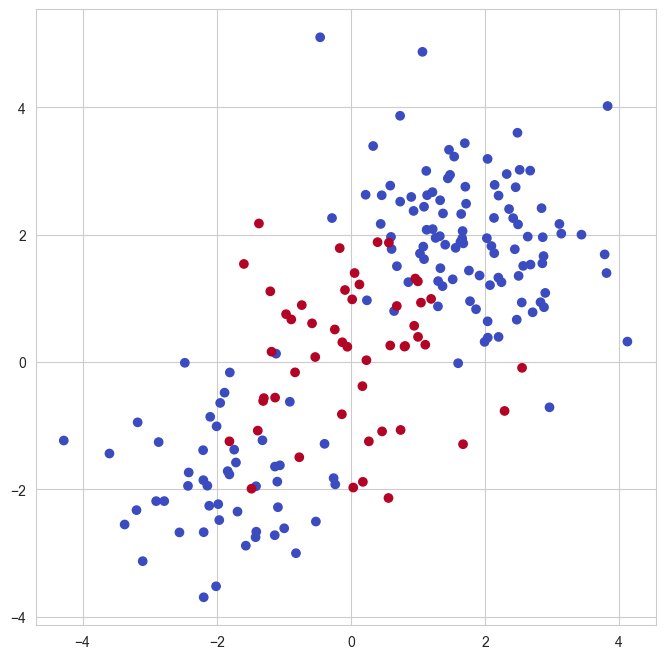

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

We randomly split the observations into training and testing partitions of equal size (using scikit-learn's `train_test_split` function). Then we use the training subset to fit a radial kernel SVM with $\gamma=1$, plotting the data and the (non-linear) decision boundary.

In [37]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.5, random_state=0)

In [38]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)

SVC(C=1, gamma=1)

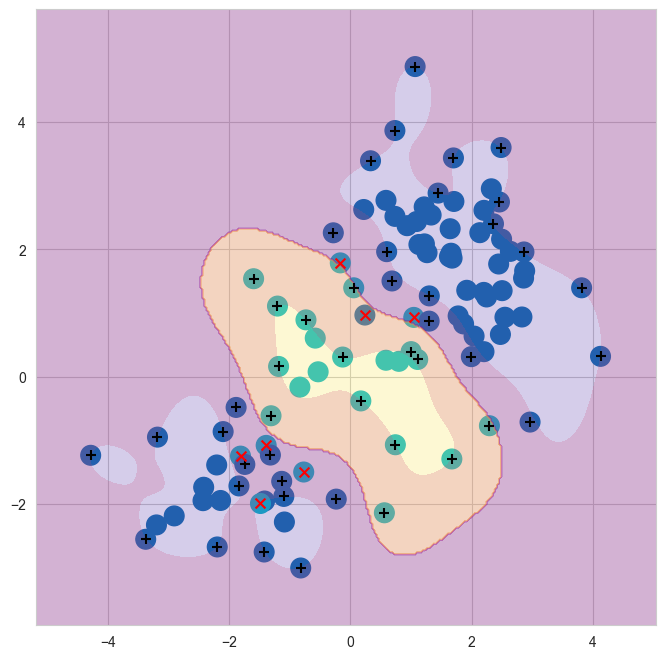

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

From the plot, it seems like that there are some training errors. We can try to reduce them by increasing `C`. However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data.

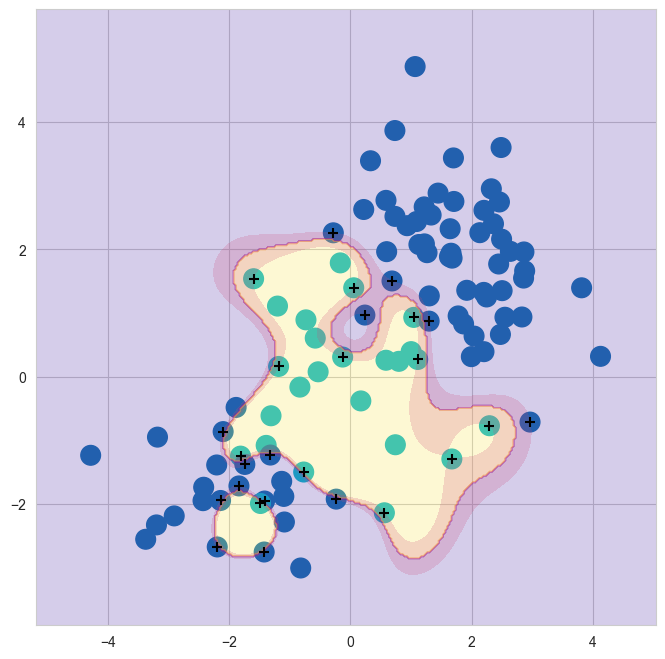

In [40]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

Instead of trying "by hand" different values of `C`, we follow a tuning approach through cross-validation, as we did for the linear SVM. This time we need to tune also the `gamma` parameter.

In [41]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

params = {"C": C_range, "gamma": gamma_range}

kfold = skm.KFold(5, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_rbf, param_grid=params, refit=True, cv=kfold, scoring="accuracy")
grid.fit(X_train, y_train)
grid.best_params_

{'C': 1, 'gamma': 0.5}

The best choice of parameters under five-fold CV is achieved at `C=1` and `gamma=0.5`.

We can now fit a SVM model with the optimal values of `C` and `gamma`:

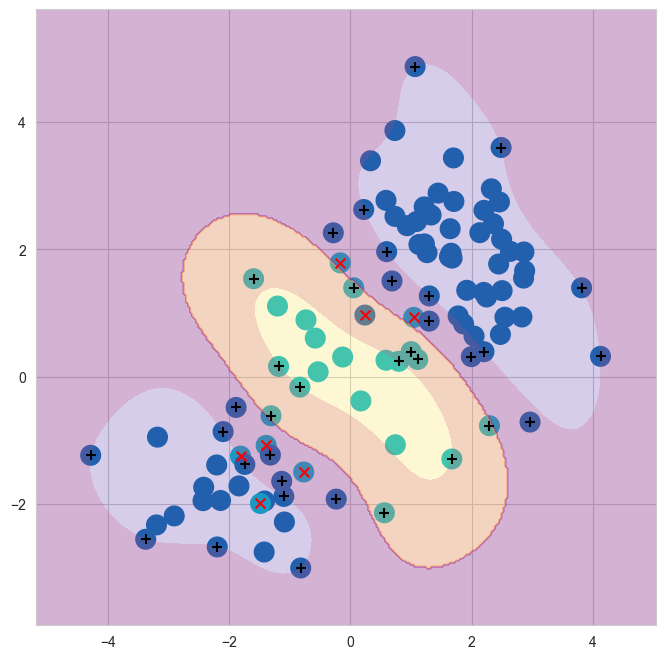

In [42]:
best_svm = grid.best_estimator_

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X_train, y_train, best_svm, ax=ax)

In [43]:
y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

Truth,1,2
Predicted,,
1,71,8
2,4,17


In [44]:
(y_hat_test != y_test).mean()

np.float64(0.12)

In [45]:
best_svm.support_vectors_.shape

(42, 2)

With these parameters, 12% of test
observations are misclassified by this SVM.

# ROC curves

[In the textbook: Section 9.6.3]

The ROC curves are a useful diagnostic tool for interpreting the performance of a binary classifier: they summarize in a plot the trade-off between the _true positive rate_ and the _false positive rate_ for different probability thresholds.

---

Here is a brief recap from Lab #1 (see also the textbook, pages 150-152).

The ingredients of the ROC curve are:

* *sensitivity* (or *recall*, or *true positive rate*) = TP / (TP + FN)
* *specificity* (or *true negative rate*) = TN / (TN + FP)
* *false positive rate* = FP / (FP + TN) = 1 - specificity

where TP (true positives), TN (true negatives), FP (false positives), and FN (false negatives) are the four cells of the confusion matrix: TP and TN stay on the main diagonal; FP and FN on the antidiagonal.

ROC curves are obtained by plotting the sensitivity vs. the false positive rate, which is 1 - specificity.

---

In [46]:
scoring = {
    'accuracy': 'accuracy',
}

Recalling what we did in Lab #1, we would need a function for drawing a ROC curve using as inputs a vector of numerical scores for each observations (`pred`), and a vector of true labels (`truth`).

Getting `pred` for SVMs is a little bit tricky. We know so far that SVMs output class labels of each observation, but we can also get the *fitted values*, i.e., the numerical scores representing whether a predicted sample lies to the right or left side of the hyperplane and how far from it.

For a support vector classifier, the fitted value for an observation $X=(X_1,X_2, \ldots, X_p)^T$ takes the form  $\hat{\beta}_0 + \hat{\beta}_1X_1 + \hat{\beta}_2X_2 + \ldots + \hat{\beta}_pX_p = \hat{\beta}_0 + \beta^T X$. For non-linear SVMs, see equation 9.23 in the textbook. Basically, if the fitted value for a given observation is $>0$, that observation gets assigned to one class, otherwise to the other.

We can access these fitted values by calling the `decision_function()` method of a fitted SVM estimator.

The scikit-learn function `RocCurveDisplay.from_estimator()` (which here is abbreviated to `roc_curve()`) will produce a plot of a ROC curve. It takes a fitted estimator, followed by a data matrix and the corresponding labels.
The argument `name` is used in the legend, while `color` is used for the color of the line.

In [47]:
roc_curve = RocCurveDisplay.from_estimator  # shorthand

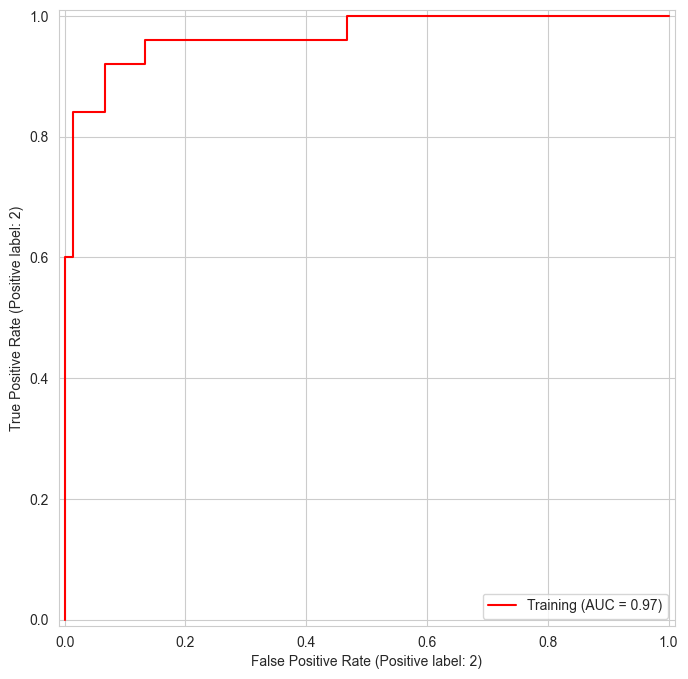

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(best_svm, X_train, y_train, name="Training", color="r", ax=ax);

Next we compare with the ROC curve corresponding to a more flexible fit with higher $\gamma$:

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_3599/1250566963.py:5: SyntaxWarning: invalid escape sequence '\g'
  roc_curve(svm_flex, X_train, y_train, name="Training $\gamma=50$", color="r", ax=ax);


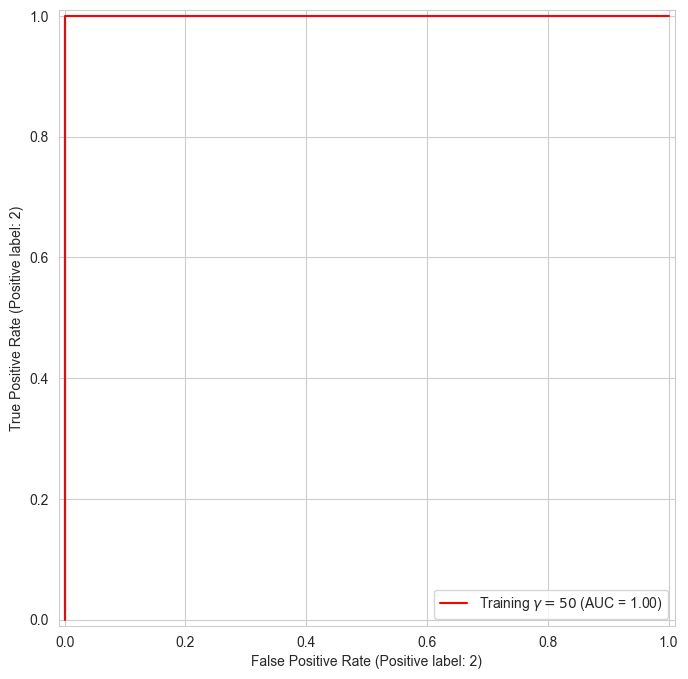

In [49]:
svm_flex = SVC(kernel="rbf", gamma=50, C=1)
svm_flex.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(svm_flex, X_train, y_train, name="Training $\gamma=50$", color="r", ax=ax);

The curve corresponding to the model with $\gamma=50$ looks better.

But what threshold are we changing for computing the ROC curve of a SVM? 

We remember that the predicted label $\hat{y}$ is given by $\hat{y} = sign(\hat{\beta}_0 + \beta^TX)$. In equivalent terms, $\hat{y}=0$ if $\hat{\beta}_0 + \beta^TX < 0$, $\hat{y}=1$ otherwise. 

We can control the positive detection rate by introducing a threshold $\epsilon$ so that $\hat{y}=0$ if $\hat{\beta}_0 + \beta^TX < \epsilon$, $\hat{y}=1$ otherwise. So the ROC curve is computed by varying this $\epsilon$.

We derived ROC curves only on the training data so far! We are more interested in assessing the performance on the test data.

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_3599/3479614996.py:2: SyntaxWarning: invalid escape sequence '\g'
  roc_curve(svm_flex, X_test, y_test, name="Test $\gamma=50$", color="b", ax=ax);


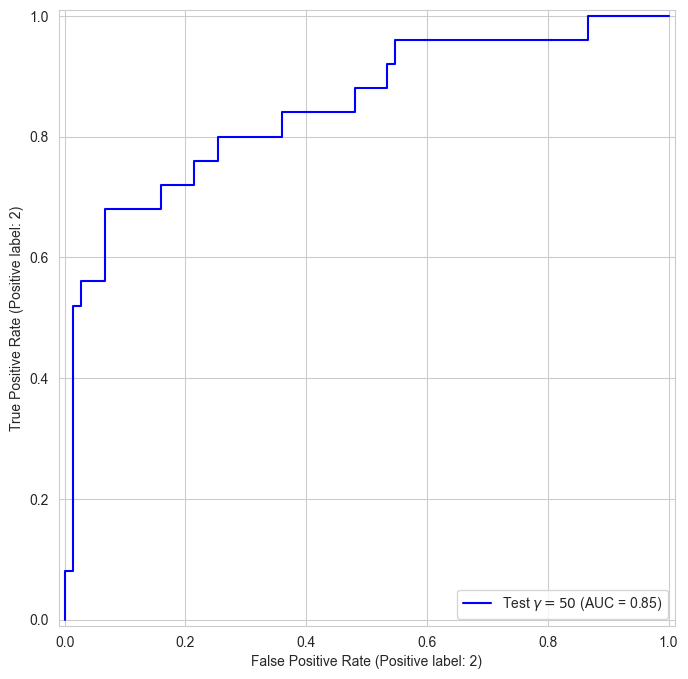

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(svm_flex, X_test, y_test, name="Test $\gamma=50$", color="b", ax=ax);

<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_3599/2421432327.py:4: SyntaxWarning: invalid escape sequence '\g'
  svm_flex, X_train, y_train, name="SVM $\gamma=50$ on training", ax=ax, color="r"
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_3599/2421432327.py:7: SyntaxWarning: invalid escape sequence '\g'
  roc_curve(svm_flex, X_test, y_test, name="SVM $\gamma=50$ on test", ax=ax, color="b");


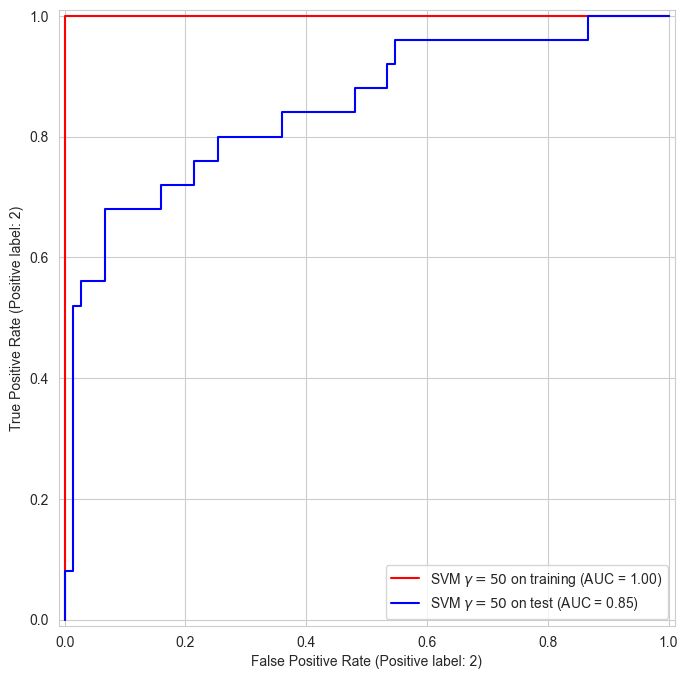

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))

roc_curve(
    svm_flex, X_train, y_train, name="SVM $\gamma=50$ on training", ax=ax, color="r"
)

roc_curve(svm_flex, X_test, y_test, name="SVM $\gamma=50$ on test", ax=ax, color="b");

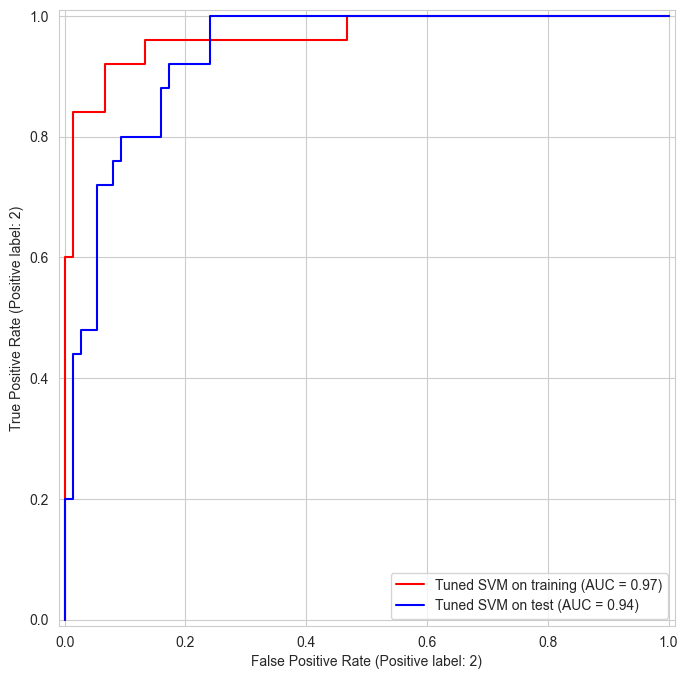

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))

roc_curve(best_svm, X_train, y_train, name="Tuned SVM on training", ax=ax, color="r")

roc_curve(best_svm, X_test, y_test, name="Tuned SVM on test", ax=ax, color="b");

When we compute the ROC curves on the test data, the model with $\gamma=0.5$ appears to provide the most accurate results.

# Multiclass SVM

[In the textbook: Section 9.6.4]

The `SVC()` function will perform automatically multi-class classification when the response variable contains more than 2 levels. The approach for multi-class classification can be either the **one-versus-one** approach (when `decision_function_shape=='ovo'`) or **one-versus-rest**, also known as one-versus-all (when `decision_function_shape=='ovr'`). Note that one-versus-rest is the default choice in `SVC()`.

We see an example on synthetic 3-class data:

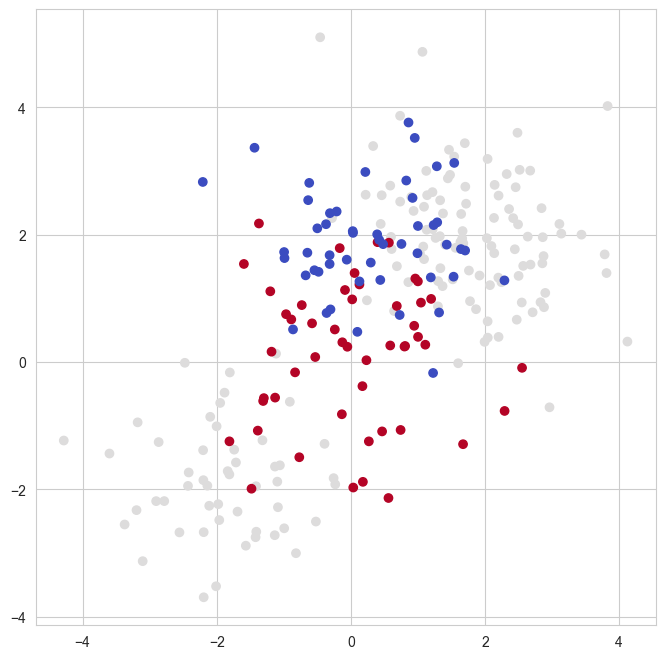

In [53]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0] * 50])
X[y == 0, 1] += 2

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

We now fit an SVM to the data, picking the "one-versus-one" approach:

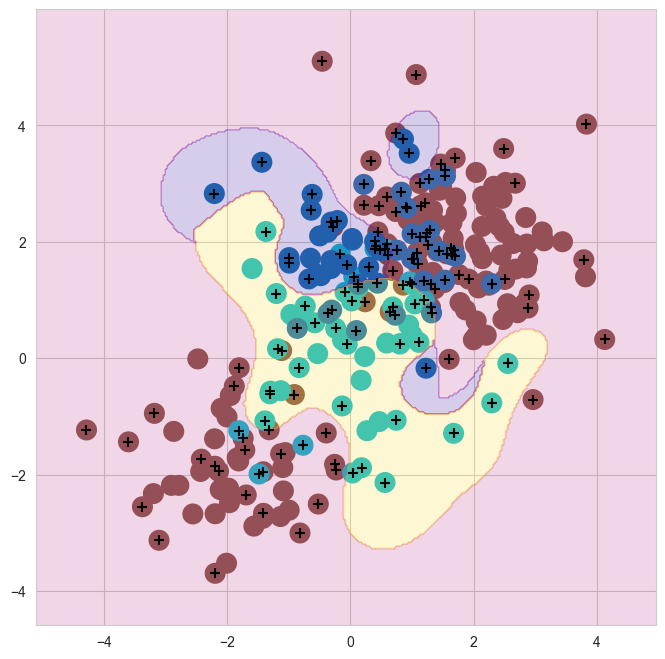

In [54]:
svm_rbf_3 = SVC(kernel="rbf", C=10, gamma=1, decision_function_shape="ovo")
svm_rbf_3.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(X, y, svm_rbf_3, scatter_cmap=plt.cm.tab10, ax=ax)

# Application to Gene Expression Data

Let's switch to a real-world data set. We use the `Khan` data, consisting of gene expression measurements for a number of tissue samples (observations) corresponding to four types of small round blue cell tumors. The observations and labels are already partitioned into a training set (`xtrain`, `ytrain`) and a testing set (`xtest`, `ytest`).

In [55]:
Khan = load_data("Khan")

First get a grasp on the data by looking at the variable names and the dimensions:

In [56]:
Khan["xtrain"].head()

,G0001,G0002,G0003,G0004,G0005,G0006,G0007,G0008,G0009,G0010,...,G2299,G2300,G2301,G2302,G2303,G2304,G2305,G2306,G2307,V2308
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966


In [57]:
Khan["xtrain"].shape

(63, 2308)

In [58]:
Khan["xtest"].shape

(20, 2308)

What is the label stratification?

In [59]:
Khan["ytrain"].value_counts()

Y
2    23
4    20
3    12
1     8
Name: count, dtype: int64

In [60]:
Khan["ytrain"].value_counts(normalize=True)

Y
2    0.365079
4    0.317460
3    0.190476
1    0.126984
Name: proportion, dtype: float64

We will use a support vector approach to predict cancer subtype using gene expression measurements.  In this data set, there is a very large number of features relative to the number of observations. This
suggests that we should use a linear kernel, because the additional flexibility that will result from using a polynomial or radial kernel is unnecessary. 

In [61]:
khan_linear = SVC(kernel="linear", C=10)
khan_linear.fit(Khan["xtrain"], Khan["ytrain"])

ypred_tr = khan_linear.predict(Khan["xtrain"])
confusion_table(ypred_tr, Khan["ytrain"])

Truth,1,2,3,4
Predicted,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


That's right: there are _no_ training errors! This is related to the "features $\gg$ observations" situation: it is easier to find a hyperplane that fully separates the classes.

We now wonder how well this model performs on the testing data: let's find out. _Remember that nothing can be said on the performance and generalization ability of a model until you evaluate it on unseen data._

In [62]:
ypred_ts = khan_linear.predict(Khan["xtest"])
confusion_table(ypred_ts, Khan["ytest"])

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


That was not so bad: only two test errors!

_Further improvements_: this performance comes from a single training/testing partition. In order to get more precise performance estimates, one could repeat the procedure on different partitions, for example using a $k$-fold Cross-Validation approach.